In [3]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer # type: ignore


## Read fingerprint file and experimental file

read fingerprint file and experiment data file

In [4]:
receptors = pd.read_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file.csv') # selected only existing binding receptors left
fingerprints = pd.read_csv('../MACCS_fingerprints.csv')
print(receptors.head())



  receptor gprotein       drug        Emax    Emax_SE     TCoeff  TCoeff_SE  \
0    5HT1A      GoB  25C-NBOMe   13.047601   1.862662   7.863330   0.215495   
1    5HT1D      Gi2  25C-NBOMe   61.560000  16.200000   7.308909   0.275469   
2    5HT2A    BArr2  25C-NBOMe  126.520000   2.660000  10.852095   0.045687   
3    5HT2A      G11  25C-NBOMe   97.880000   1.930000  11.570638   0.051133   
4    5HT2A      G15  25C-NBOMe   89.690000   2.150000  11.482661   0.057973   

     logEmEC  logEmEc_Lower  logEmEc_Upper    pEC50  pEC50_SE  N  
0   7.866311       7.488600       8.235079  6.75078  0.310814  3  
1   7.319299       6.826673       7.780756  5.53000  0.360000  3  
2  10.852159      10.772931      10.931195  8.75000  0.070000  3  
3  11.570694      11.482045      11.659174  9.58000  0.080000  3  
4  11.482744      11.382207      11.583032  9.53000  0.090000  3  


### Experimental data processing

binarize the experiment data file -> create multilabel for receptors

In [5]:
# collect receptors for each drug
drug_receptor_mapping = receptors.groupby('drug')['receptor'].apply(list).reset_index()
print(drug_receptor_mapping.head())

         drug                                           receptor
0   25C-NBOMe  [5HT1A, 5HT1D, 5HT2A, 5HT2A, 5HT2A, 5HT2A, 5HT...
1    25I-NBMD  [5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT1B, 5HT1B, 5HT...
2   25I-NBOMe  [5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT1D, 5HT...
3  25T7-NBOMe  [5HT1A, 5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT...
4  4-AcO-MALT  [5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT...


In [6]:
# binarize the receptors
mlb = MultiLabelBinarizer()
receptor_labels = mlb.fit_transform(drug_receptor_mapping['receptor'])

In [7]:
drug_receptor_label = pd.concat([drug_receptor_mapping, pd.DataFrame(receptor_labels, columns=mlb.classes_)], axis=1)
print(drug_receptor_label.head())

         drug                                           receptor  5HT1A  \
0   25C-NBOMe  [5HT1A, 5HT1D, 5HT2A, 5HT2A, 5HT2A, 5HT2A, 5HT...      1   
1    25I-NBMD  [5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT1B, 5HT1B, 5HT...      1   
2   25I-NBOMe  [5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT1D, 5HT...      1   
3  25T7-NBOMe  [5HT1A, 5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT...      1   
4  4-AcO-MALT  [5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT...      1   

   5HT1B  5HT1D  5HT1E  5HT1F  5HT2A  5HT2B  5HT2C  ...  Alpha2A  Alpha2B  \
0      0      1      0      0      1      1      1  ...        0        0   
1      1      1      1      1      1      1      1  ...        0        0   
2      0      1      1      1      1      1      1  ...        0        0   
3      0      1      0      1      1      1      1  ...        0        0   
4      1      1      1      1      1      1      1  ...        0        0   

   Alpha2C  Beta2AR  Beta3AR  DRD1  DRD2  DRD3  DRD4  DRD5  
0        0        0      

In [8]:
drug_label = drug_receptor_label.drop(columns=['receptor'])
print(drug_label.head())
# drug_label.to_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file_multilabel.csv', index=False)

drug_dict = drug_label.to_dict()
print(drug_dict)

         drug  5HT1A  5HT1B  5HT1D  5HT1E  5HT1F  5HT2A  5HT2B  5HT2C  5HT5A  \
0   25C-NBOMe      1      0      1      0      0      1      1      1      0   
1    25I-NBMD      1      1      1      1      1      1      1      1      0   
2   25I-NBOMe      1      0      1      1      1      1      1      1      1   
3  25T7-NBOMe      1      0      1      0      1      1      1      1      1   
4  4-AcO-MALT      1      1      1      1      1      1      1      1      1   

   ...  Alpha2A  Alpha2B  Alpha2C  Beta2AR  Beta3AR  DRD1  DRD2  DRD3  DRD4  \
0  ...        0        0        0        0        0     0     1     0     0   
1  ...        0        0        0        0        0     0     0     0     0   
2  ...        0        0        0        0        0     0     0     1     0   
3  ...        0        0        0        0        0     0     0     1     0   
4  ...        0        0        0        0        0     0     1     1     0   

   DRD5  
0     0  
1     0  
2     0  
3   

### Fingerprint data processing

In [9]:
# Extract the names (first column)
drug_names_fingerprints = fingerprints['Name']
fingerprints_detail = fingerprints.drop('Name', axis=1)  # Drop the name column by index

# Create a dictionary where names are keys and fingerprints are lists of values
# csv_dict = {name: fingerprint.tolist() for name, fingerprint in zip(drug_names_fingerprints, fingerprints_detail.values)}


### Merge feature and labels

merge features and labels -> to ensure the features and labels match based on drugs

In [10]:
# merge the two dataframes based on the drug name
data_merged = pd.merge(fingerprints, drug_label, left_on="Name", right_on="drug").drop(
    columns=["Name"]
)
data_merged.to_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/data_merged.csv', index=False)

print(data_merged.shape)

(40, 192)


# Training

In [11]:
X = data_merged.drop(columns=['drug'] + list(mlb.classes_))
y = data_merged[list(mlb.classes_)]

print(X.shape, y.shape)


(40, 167) (40, 24)


In [16]:
print(X.head())

   0  1  2  3  4  5  6  7  8  9  ...  2038  2039  2040  2041  2042  2043  \
0  0  0  0  0  0  0  0  0  1  0  ...     1     0     0     0     0     0   
1  0  0  0  0  0  0  1  0  1  0  ...     1     0     0     0     0     0   
2  0  0  0  0  0  0  1  0  1  0  ...     1     0     0     0     0     0   
3  0  0  0  1  0  0  0  0  1  1  ...     1     0     0     1     0     0   
4  1  0  0  1  0  1  1  1  1  1  ...     1     0     0     1     0     0   

   2044  2045  2046  2047  
0     0     0     0     1  
1     0     0     0     1  
2     0     0     0     1  
3     0     0     0     1  
4     0     0     0     1  

[5 rows x 2048 columns]


## Optuna + Nested CV

In [75]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    f1_score,
    jaccard_score,
    make_scorer,
)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
import numpy as np

# Nested cross-validation setup
outer_ncv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = KFold(n_splits=5, shuffle=True, random_state=42)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(
        hamming_loss, greater_is_better=False
    )  # Minimize Hamming loss
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return -cv_scores.mean() # -cv mean because make_scorer is greater_is_better=False, which will give negative values of hamming loss


In [76]:
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    f1_score,
    jaccard_score,
    roc_auc_score,
)
import numpy as np

# Outer loop: Statistical evaluation
outer_scores = []
label_scores = {label: [] for label in y.columns}
outer_scores_auc = []


for train_index, test_index in outer_ncv.split(X, y):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Get predicted probabilities
    # y_test_pred_proba = best_rf_classifier.predict_proba(X_test)

    # Convert predicted probabilities to predicted labels 
    y_test_pred = best_rf_classifier.predict(X_test) # could change to predict_proba using different threshold to predict labels

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "hamming_loss": hamming_loss(y_test, y_test_pred),
            "f1_micro": f1_score(y_test, y_test_pred, average="micro"),
            "jaccard_samples": jaccard_score(y_test, y_test_pred, average="samples"),
        }
    )
    

    # Calculate metrics for each label
    for label in y.columns:
        label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )
        
    
# Calculate mean and standard deviation for overall metrics
metrics = {key: [score[key] for score in outer_scores] for key in outer_scores[0]}
for metric, values in metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )
    

[I 2025-01-03 11:04:01,850] A new study created in memory with name: no-name-4d742c3a-b587-447b-9fd8-6a79974e3416
[I 2025-01-03 11:04:02,226] Trial 0 finished with value: 0.12063492063492062 and parameters: {'n_estimators': 55, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.12063492063492062.
[I 2025-01-03 11:04:03,618] Trial 1 finished with value: 0.11567460317460318 and parameters: {'n_estimators': 195, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.11567460317460318.
[I 2025-01-03 11:04:04,205] Trial 2 finished with value: 0.12063492063492062 and parameters: {'n_estimators': 55, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.11567460317460318.
[I 2025-01-03 11:04:04,502] Trial 3 finished with value: 0.11587301587301586 and parameters: {'n_estimators': 58, 'max_depth': 6, 'min_samples_spli

Accuracy: Mean = 0.07, Std = 0.06
Hamming_loss: Mean = 0.12, Std = 0.03
F1_micro: Mean = 0.90, Std = 0.03
Jaccard_samples: Mean = 0.80, Std = 0.06


In [42]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'n_estimators': 46, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}


### Evaluation

"accuracy", "hamming_loss", "f1_score", "jaccard_score"

/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

Accuracy: Mean = 0.05, Std = 0.06
Hamming_loss: Mean = 0.12, Std = 0.03
F1_micro: Mean = 0.90, Std = 0.03
Jaccard_samples: Mean = 0.80, Std = 0.05

Metrics for label: 5HT1A
Accuracy: Mean = 0.95, Std = 0.06
Hamming_loss: Mean = 0.05, Std = 0.06
F1_score: Mean = 0.97, Std = 0.03
Jaccard_score: Mean = 0.95, Std = 0.06

Metrics for label: 5HT1B
Accuracy: Mean = 0.93, Std = 0.10
Hamming_loss: Mean = 0.07, Std = 0.10
F1_score: Mean = 0.96, Std = 0.06
Jaccard_score: Mean = 0.93, Std = 0.10

Metrics for label: 5HT1D
Accuracy: Mean = 1.00, Std = 0.00
Hamming_loss: Mean = 0.00, Std = 0.00
F1_score: Mean = 1.00, Std = 0.00
Jaccard_score: Mean = 1.00, Std = 0.00

Metrics for label: 5HT1E
Accuracy: Mean = 0.90, Std = 0.09
Hamming_loss: Mean = 0.10, Std = 0.09
F1_score: Mean = 0.94, Std = 0.05
Jaccard_score: Mean = 0.90, Std = 0.09

Metrics for label: 5HT1F
Accuracy: Mean = 0.97, Std = 0.05
Hamming_loss: Mean = 0.03, Std = 0.05
F1_score: Mean = 0.99, Std = 0.03
Jaccard_score: Mean = 0.97, Std = 0.0

/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

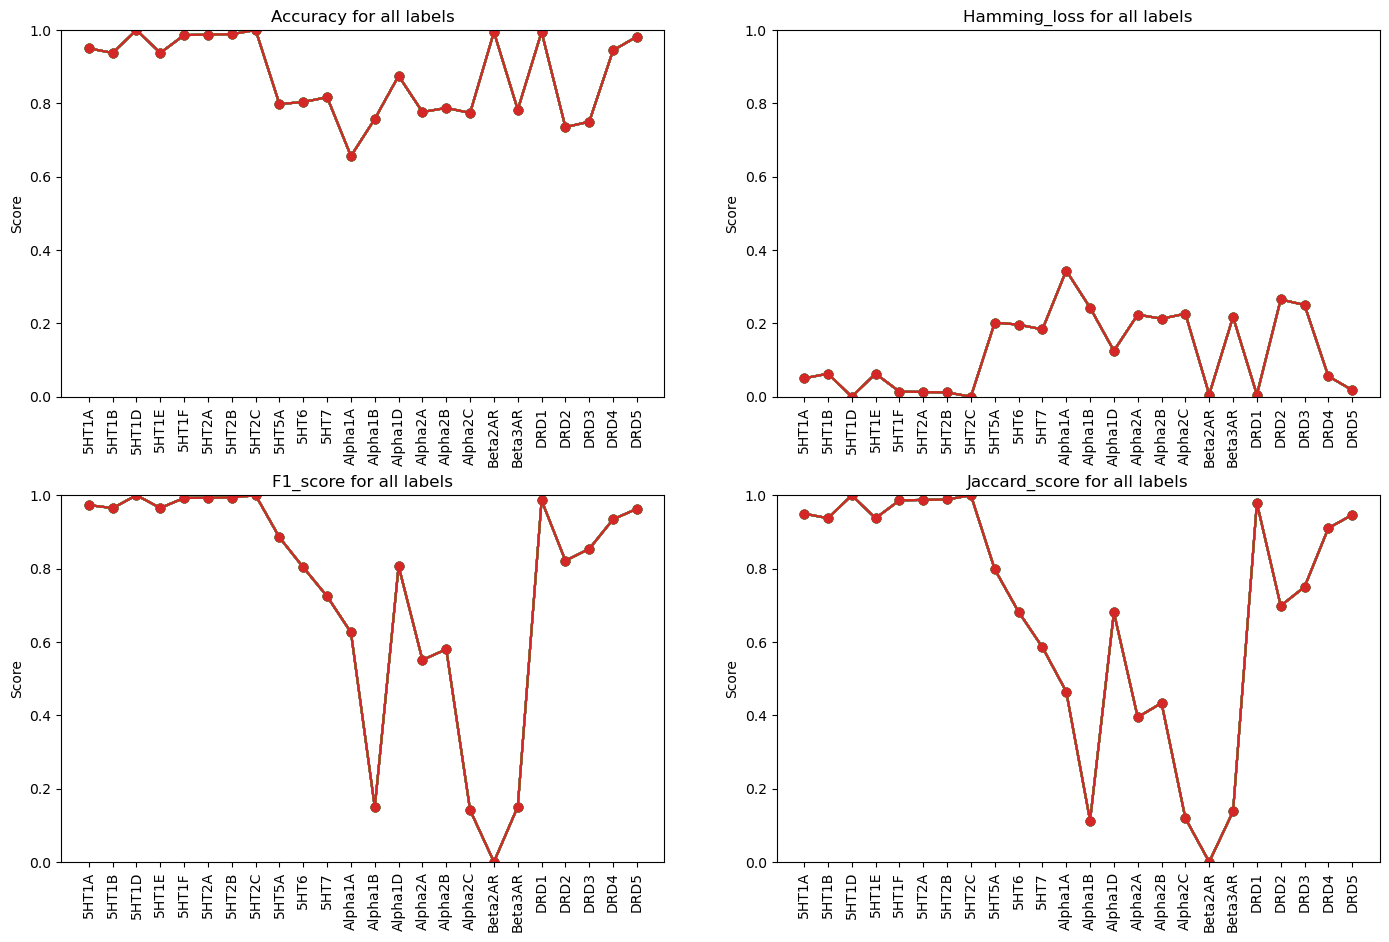

In [ ]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation for overall metrics
metrics = {key: [score[key] for score in outer_scores] for key in outer_scores[0]}
for metric, values in metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )
    
# Calculate mean and standard deviation for each label's metrics
for label, scores in label_scores.items():
    print(f"\nMetrics for label: {label}")
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    for metric, values in label_metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )
    

# Calculate mean and standard deviation for each label's metrics
label_metrics_summary = {}
for label, scores in label_scores.items():
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    label_metrics_summary[label] = {
        metric: (np.mean(values), np.std(values))
        for metric, values in label_metrics.items()
    }

    # Calculate metrics for each label
    for label in y.columns:
        label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )

# Plotting the metrics for each label
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)


for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    for label in y.columns:
        means = [label_metrics_summary[label][metric][0] for label in y.columns]
        stds = [label_metrics_summary[label][metric][1] for label in y.columns]
        ax.plot(y.columns, means, marker="o", label=label)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    # ax.legend()
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    means = [label_metrics_summary[label][metric][0] for label in y.columns]
    stds = [label_metrics_summary[label][metric][1] for label in y.columns]

    ax.plot(range(len(y.columns)), means, marker="o")
    ax.fill_between(
        range(len(y.columns)),
        np.array(means) - np.array(stds),
        np.array(means) + np.array(stds),
        alpha=0.2,
    )

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()


## Optuna + CV

In [68]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    f1_score,
    jaccard_score,
    make_scorer,
)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
import numpy as np

# cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(
        hamming_loss, greater_is_better=False
    )  # Minimize Hamming loss
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=kf, scoring=scoring
    )
    return -cv_scores.mean()  # -cv mean because make_scorer is greater_is_better=False, which will give negative values of hamming loss


In [69]:
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    f1_score,
    jaccard_score,
    roc_auc_score,
)
import numpy as np

# Outer loop: Statistical evaluation
cv_scores = []
cv_label_scores = {label: [] for label in y.columns}

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X, y), n_trials=10)


for train_index, test_index in kf.split(X, y):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Get predicted probabilities
    # y_test_pred_proba = best_rf_classifier.predict_proba(X_test)

    # Convert predicted probabilities to predicted labels
    y_test_pred = best_rf_classifier.predict(
        X_test
    )  # could change to predict_proba using different threshold to predict labels

    # Evaluate the model on the outer fold's test set
    cv_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "hamming_loss": hamming_loss(y_test, y_test_pred),
            "f1_micro": f1_score(y_test, y_test_pred, average="micro"),
            "jaccard_samples": jaccard_score(y_test, y_test_pred, average="samples"),
        }
    )

    # Calculate metrics for each label
    for label in y.columns:
        label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )


# Calculate mean and standard deviation for overall metrics
metrics = {key: [score[key] for score in outer_scores] for key in outer_scores[0]}
for metric, values in metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )


[I 2025-01-02 17:15:52,261] A new study created in memory with name: no-name-d6f85300-20ad-44e1-b3e0-275e04899ed6
[I 2025-01-02 17:15:52,678] Trial 0 finished with value: 0.12261904761904763 and parameters: {'n_estimators': 81, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.12261904761904763.
[I 2025-01-02 17:15:53,087] Trial 1 finished with value: 0.13968253968253969 and parameters: {'n_estimators': 73, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.12261904761904763.
[I 2025-01-02 17:15:53,643] Trial 2 finished with value: 0.14265873015873015 and parameters: {'n_estimators': 131, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.12261904761904763.
[I 2025-01-02 17:15:54,371] Trial 3 finished with value: 0.12996031746031747 and parameters: {'n_estimators': 175, 'max_depth': 12, 'min_sample

Accuracy: Mean = 0.03, Std = 0.05
Hamming_loss: Mean = 0.13, Std = 0.03
F1_micro: Mean = 0.89, Std = 0.03
Jaccard_samples: Mean = 0.79, Std = 0.05


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, jaccard_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Simple cross-validation setup
cv = KFold(n_splits=3, shuffle=True, random_state=42)


def objective(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
        "random_state": 42,
    }

    rf_classifier = RandomForestClassifier(**params)
    scoring = "accuracy"
    cv_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring=scoring)
    return cv_scores.mean()


def train_and_evaluate(X, y):
    # Optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)

    # Initialize scores
    cv_scores = []
    cv_label_scores = {label: [] for label in y.columns}

    # Cross-validation with best parameters
    best_params = study.best_params

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train model
        best_model = RandomForestClassifier(**best_params, random_state=42)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        # Overall metrics
        cv_scores.append(
            {
                "accuracy": accuracy_score(y_test, y_pred),
                "hamming_loss": hamming_loss(y_test, y_pred),
                "f1_micro": f1_score(y_test, y_pred, average="micro"),
                "jaccard_samples": jaccard_score(y_test, y_pred, average="samples"),
            }
        )

        # Per-label metrics
        for label in y.columns:
            cv_label_scores[label].append(
                {
                    "accuracy": accuracy_score(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                    "hamming_loss": hamming_loss(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                    "f1_score": f1_score(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                    "jaccard_score": jaccard_score(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                }
            )

    # Calculate summary metrics
    print("\nOverall Metrics:")
    metrics = {key: [score[key] for score in cv_scores] for key in cv_scores[0]}
    for metric, values in metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )

    # Calculate label metrics summary
    label_metrics_summary = {}
    for label, scores in cv_label_scores.items():
        print(f"\nMetrics for label: {label}")
        label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
        label_metrics_summary[label] = {
            metric: (np.mean(values), np.std(values))
            for metric, values in label_metrics.items()
        }
        for metric, values in label_metrics.items():
            print(
                f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
            )

    # Plotting
    metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    fig.tight_layout(pad=5.0)

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        ax.set_title(f"{metric.capitalize()} for all labels")
        means = [label_metrics_summary[label][metric][0] for label in y.columns]
        stds = [label_metrics_summary[label][metric][1] for label in y.columns]

        ax.plot(range(len(y.columns)), means, marker="o")
        ax.fill_between(
            range(len(y.columns)),
            np.array(means) - np.array(stds),
            np.array(means) + np.array(stds),
            alpha=0.2,
        )

        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)
        ax.set_xticks(range(len(y.columns)))
        ax.set_xticklabels(y.columns, rotation=90)

    plt.show()

    return best_model, cv_scores, label_metrics_summary


[I 2025-01-03 10:56:54,445] A new study created in memory with name: no-name-1152a3bf-3dea-4e02-84fb-e3e9ff31587b
[I 2025-01-03 10:56:54,761] Trial 0 finished with value: 0.025641025641025644 and parameters: {'n_estimators': 47, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 0 with value: 0.025641025641025644.
[I 2025-01-03 10:56:55,020] Trial 1 finished with value: 0.04945054945054945 and parameters: {'n_estimators': 70, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 1 with value: 0.04945054945054945.
[I 2025-01-03 10:56:55,131] Trial 2 finished with value: 0.025641025641025644 and parameters: {'n_estimators': 30, 'max_depth': 15, 'min_samples_split': 3}. Best is trial 1 with value: 0.04945054945054945.
[I 2025-01-03 10:56:55,506] Trial 3 finished with value: 0.05128205128205129 and parameters: {'n_estimators': 86, 'max_depth': 15, 'min_samples_split': 2}. Best is trial 3 with value: 0.05128205128205129.
[I 2025-01-03 10:56:55,685] Trial 4 finished with value: 0.049450


Overall Metrics:
Accuracy: Mean = 0.08, Std = 0.00
Hamming_loss: Mean = 0.13, Std = 0.02
F1_micro: Mean = 0.89, Std = 0.02
Jaccard_samples: Mean = 0.80, Std = 0.03

Metrics for label: 5HT1A
Accuracy: Mean = 0.92, Std = 0.00
Hamming_loss: Mean = 0.08, Std = 0.00
F1_score: Mean = 0.96, Std = 0.00
Jaccard_score: Mean = 0.92, Std = 0.00

Metrics for label: 5HT1B
Accuracy: Mean = 0.93, Std = 0.06
Hamming_loss: Mean = 0.07, Std = 0.06
F1_score: Mean = 0.96, Std = 0.03
Jaccard_score: Mean = 0.93, Std = 0.06

Metrics for label: 5HT1D
Accuracy: Mean = 1.00, Std = 0.00
Hamming_loss: Mean = 0.00, Std = 0.00
F1_score: Mean = 1.00, Std = 0.00
Jaccard_score: Mean = 1.00, Std = 0.00

Metrics for label: 5HT1E
Accuracy: Mean = 0.90, Std = 0.03
Hamming_loss: Mean = 0.10, Std = 0.03
F1_score: Mean = 0.95, Std = 0.02
Jaccard_score: Mean = 0.90, Std = 0.03

Metrics for label: 5HT1F
Accuracy: Mean = 0.98, Std = 0.03
Hamming_loss: Mean = 0.02, Std = 0.03
F1_score: Mean = 0.99, Std = 0.02
Jaccard_score: Mean

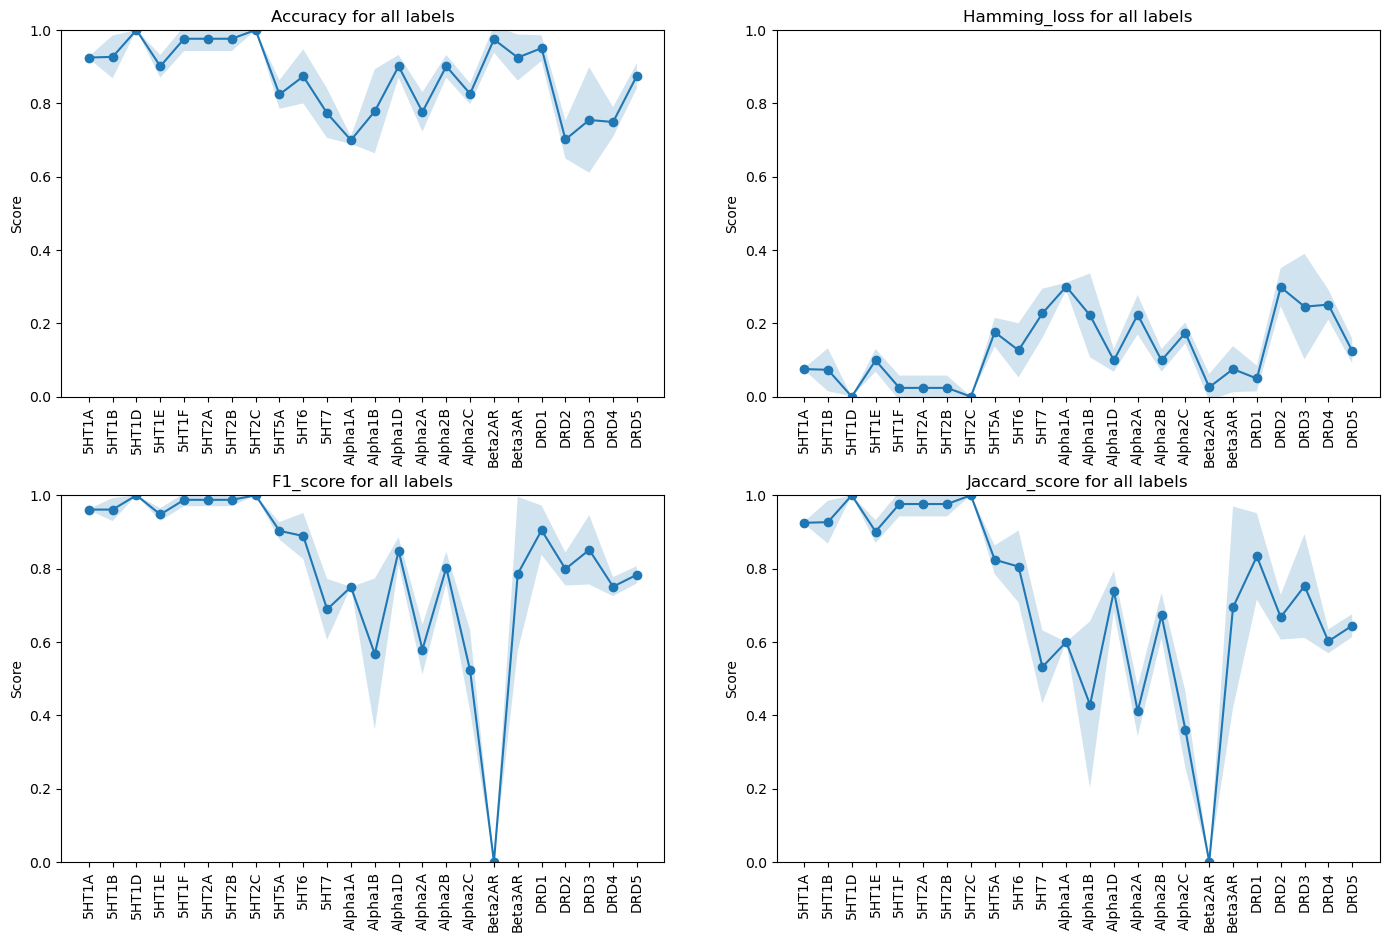

In [71]:
# Assuming you have your X and y data ready
best_model, cv_scores, label_metrics = train_and_evaluate(X, y)


## Nested CV vs Simple CV

In [ ]:
def objective(trial, X, y, inner_cv=None):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
        "random_state": 42,
    }

    rf_classifier = RandomForestClassifier(**params)

    if inner_cv is None:
        # Simple CV
        cv = KFold(n_splits=3, shuffle=True, random_state=42)
    else:
        cv = inner_cv

    cv_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring="accuracy")
    return cv_scores.mean()

In [ ]:
def evaluate_cv(X, y, cv_type="simple"):
    if cv_type == "nested":
        outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=43)
    else:
        outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
        inner_cv = None

    cv_scores = []
    cv_label_scores = {label: [] for label in y.columns}

    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Optimization
        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective(
                trial, X_train, y_train, inner_cv if cv_type == "nested" else None
            ),
            n_trials=10,
        )

        # Train model with best parameters
        best_model = RandomForestClassifier(**study.best_params, random_state=42)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        # Overall metrics
        cv_scores.append(
            {
                "accuracy": accuracy_score(y_test, y_pred),
                "hamming_loss": hamming_loss(y_test, y_pred),
                "f1_micro": f1_score(y_test, y_pred, average="micro"),
                "jaccard_samples": jaccard_score(y_test, y_pred, average="samples"),
            }
        )

        # Per-label metrics
        for label in y.columns:
            cv_label_scores[label].append(
                {
                    "accuracy": accuracy_score(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                    "hamming_loss": hamming_loss(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                    "f1_score": f1_score(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                    "jaccard_score": jaccard_score(
                        y_test[label], y_pred[:, y.columns.get_loc(label)]
                    ),
                }
            )

    # Calculate summary metrics
    print(f"\n{cv_type.upper()} CV Overall Metrics:")
    metrics = {key: [score[key] for score in cv_scores] for key in cv_scores[0]}
    for metric, values in metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )

    # Calculate label metrics summary
    label_metrics_summary = {}
    for label, scores in cv_label_scores.items():
        print(f"\nMetrics for label: {label}")
        label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
        label_metrics_summary[label] = {
            metric: (np.mean(values), np.std(values))
            for metric, values in label_metrics.items()
        }
        for metric, values in label_metrics.items():
            print(
                f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
            )

    return label_metrics_summary


In [ ]:
def plot_cv_comparison(simple_metrics, nested_metrics, y_columns):
    metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    fig.tight_layout(pad=5.0)

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        ax.set_title(f"{metric.capitalize()} Comparison")

        # Simple CV
        simple_means = [simple_metrics[label][metric][0] for label in y_columns]
        simple_stds = [simple_metrics[label][metric][1] for label in y_columns]

        # Nested CV
        nested_means = [nested_metrics[label][metric][0] for label in y_columns]
        nested_stds = [nested_metrics[label][metric][1] for label in y_columns]

        # Plot lines
        x = range(len(y_columns))
        ax.plot(x, simple_means, "b-", marker="o", label="Simple CV")
        ax.fill_between(
            x,
            np.array(simple_means) - np.array(simple_stds),
            np.array(simple_means) + np.array(simple_stds),
            alpha=0.2,
            color="blue",
        )

        ax.plot(x, nested_means, "r-", marker="s", label="Nested CV")
        ax.fill_between(
            x,
            np.array(nested_means) - np.array(nested_stds),
            np.array(nested_means) + np.array(nested_stds),
            alpha=0.2,
            color="red",
        )

        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)
        ax.legend()
        ax.set_xticks(range(len(y_columns)))
        ax.set_xticklabels(y_columns, rotation=90)

    plt.show()

In [ ]:
def compare_cv_approaches(X, y):
    # Run both CV approaches
    simple_metrics = evaluate_cv(X, y, cv_type="simple")
    nested_metrics = evaluate_cv(X, y, cv_type="nested")

    # Plot comparison
    plot_cv_comparison(simple_metrics, nested_metrics, y.columns)

    return simple_metrics, nested_metrics

In [ ]:
# Assuming you have your X and y data ready
simple_metrics, nested_metrics = compare_cv_approaches(X, y)